# MNIST Simplicial Interpolation Analysis

This notebook implements and evaluates a **Local Simplicial Interpolator** for robust classification on the MNIST digit dataset. The method uses topological concepts from simplicial complexes to perform interpolation within convex hulls of training data.

## Overview

The Local Simplicial Interpolator (LSI) addresses classification by:
1. Finding k-nearest neighbors for each test point
2. Using linear programming to determine if the test point lies within the convex hull (simplex) of these neighbors
3. If inside the hull, predicting via convex combination of neighbor labels
4. If outside, marking as uncovered

## Goal of the study

- **Geometric Interpolation**: Leverages simplicial geometry for smooth interpolation
- **Noise Robustness**: Evaluates performance under controlled label noise (0-30%)
- **Coverage Analysis**: Measures what fraction of test points can be interpolated
- **Baseline Comparison**: Compares against 1-Nearest Neighbor classifier




In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import linprog
from sklearn.metrics import accuracy_score

class LocalSimplicialInterpolator:
    def __init__(self, k_neighbors=30):
        """
        k_neighbors: How many local points to consider when trying to find an 
                     enclosing simplex. Must be > dimensionality.
        """
        self.k = k_neighbors
        self.X_train = None
        self.y_train = None
        self.nbrs = None
        self.classes_ = None

    def fit(self, X, y):
        self.X_train = X
        self.classes_ = np.unique(y)
        self.y_train = np.eye(len(self.classes_))[y]
        
        self.nbrs = NearestNeighbors(n_neighbors=self.k, algorithm='auto').fit(X)
        return self

    def predict(self, X_test):
        n_samples = X_test.shape[0]
        n_classes = len(self.classes_)
        y_pred = np.zeros(n_samples)
        
        inside_hull_count = 0
        
        _, indices_all = self.nbrs.kneighbors(X_test)
        
        print(f"Processing {n_samples} test points (solving LP for each)...")
        
        for i in range(n_samples):

            local_indices = indices_all[i]
            X_local = self.X_train[local_indices]  # Shape (k, d)
            y_local = self.y_train[local_indices]  # Shape (k, n_classes)
            x_target = X_test[i]
            
            c = np.zeros(self.k) 
            
            
            A_eq = np.vstack([X_local.T, np.ones((1, self.k))])
            b_eq = np.concatenate([x_target, [1.0]])
            
            res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, None), method='highs')
            
            if res.success:
                weights = res.x
                pred_probs = weights @ y_local
                y_pred[i] = np.argmax(pred_probs)
                inside_hull_count += 1
            else:
                y_pred[i] = -1 

        coverage_pct = (inside_hull_count / n_samples) * 100
        print(f"\nCompleted. Simplicial Coverage: {coverage_pct:.2f}% of test points were inside a hull.")
        return y_pred



## Dimensionality Impact Experiment

This cell demonstrates how simplicial interpolation performance varies with PCA dimensionality under fixed noise conditions.

### Experiment Setup
- **Dataset**: Full MNIST (70,000 samples)
- **Noise Level**: Fixed at 20% label corruption
- **Dimensions Tested**: 3 through 8 (range(3, 9))
- **k_neighbors**: max(20, pca_dims × 5) - scales with dimensionality to ensure sufficient hull candidates

### Methodology
For each dimension d ∈ {3,4,5,6,7,8}:
1. Apply PCA to reduce MNIST to d dimensions
2. Split data (90% train, 10% test)
3. Inject 20% random label noise into training set
4. Train LocalSimplicialInterpolator with dimension-scaled k_neighbors
5. Predict on test set and measure:
   - **Coverage**: Fraction of test points inside some training simplex
   - **Accuracy**: Classification accuracy on covered points only

### Visualization
Dual-axis plot showing:
- **Blue line**: Accuracy on covered points (left y-axis)
- **Orange dashed line**: Coverage percentage (right y-axis)
- **X-axis**: PCA dimensions (3-8)

This experiment isolates the dimensionality effect while holding noise constant, complementing the comprehensive noise-vs-dimension analysis in the final cell.

Testing PCA dimension: 3
Processing 7000 test points (solving LP for each)...

Completed. Simplicial Coverage: 98.66% of test points were inside a hull.
  Accuracy: 41.21%, Coverage: 98.66%
Testing PCA dimension: 4
Processing 7000 test points (solving LP for each)...

Completed. Simplicial Coverage: 90.97% of test points were inside a hull.
  Accuracy: 53.86%, Coverage: 90.97%
Testing PCA dimension: 5
Processing 7000 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.51% of test points were inside a hull.
  Accuracy: 63.83%, Coverage: 79.51%
Testing PCA dimension: 6
Processing 7000 test points (solving LP for each)...

Completed. Simplicial Coverage: 60.41% of test points were inside a hull.
  Accuracy: 73.52%, Coverage: 60.41%
Testing PCA dimension: 7
Processing 7000 test points (solving LP for each)...

Completed. Simplicial Coverage: 41.41% of test points were inside a hull.
  Accuracy: 76.68%, Coverage: 41.41%
Testing PCA dimension: 8
Processing 7000 test poin

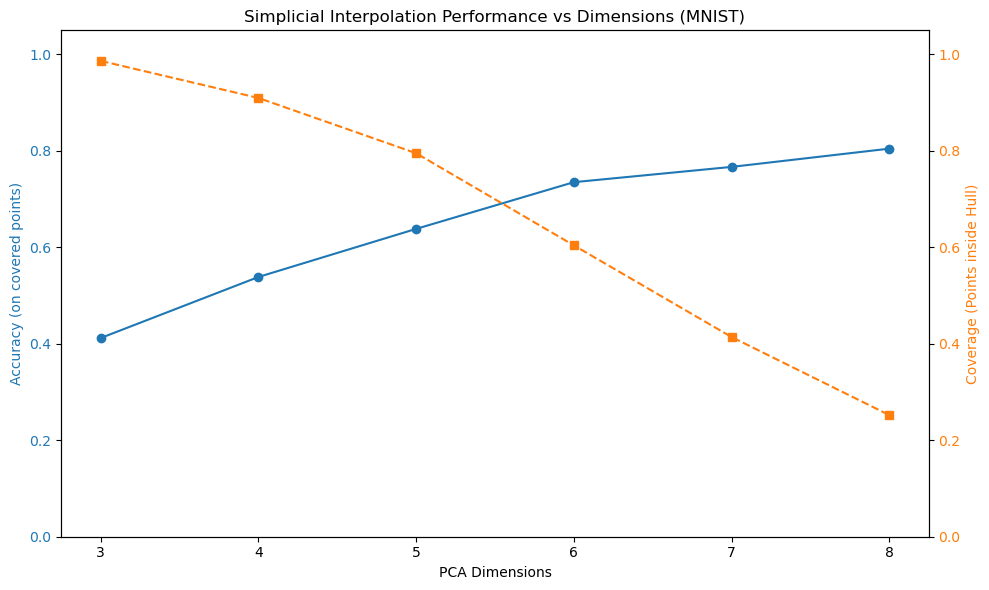

In [ ]:
X_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
y_raw = y_raw.astype(int)
X_raw = X_raw / 255.0

pca_dims_list = range(3, 9)
accuracies = []
coverages = []

noise_level = 0.20

for pca_dims in pca_dims_list:
    print(f"Testing PCA dimension: {pca_dims}")
    
    pca = PCA(n_components=pca_dims)
    X_pca = pca.fit_transform(X_raw)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_raw, test_size=0.1, random_state=42)

    n_train = len(y_train)
    n_noise = int(noise_level * n_train)
    noise_indices = np.random.choice(n_train, n_noise, replace=False)
    y_train_noisy = y_train.copy()
    
    for idx in noise_indices:
        current_label = y_train[idx]
        possible = list(range(10))
        possible.remove(current_label)
        y_train_noisy[idx] = np.random.choice(possible)

    model = LocalSimplicialInterpolator(k_neighbors=max(20, pca_dims * 5))
    model.fit(X_train, y_train_noisy)
    preds = model.predict(X_test)

    valid_mask = preds != -1
    coverage = np.mean(valid_mask)
    
    if np.sum(valid_mask) > 0:
        acc = accuracy_score(y_test[valid_mask], preds[valid_mask])
    else:
        acc = 0.0
        
    accuracies.append(acc)
    coverages.append(coverage)
    print(f"  Accuracy: {acc*100:.2f}%, Coverage: {coverage*100:.2f}%")

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('PCA Dimensions')
ax1.set_ylabel('Accuracy (on covered points)', color=color)
ax1.plot(pca_dims_list, accuracies, marker='o', color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1.05)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Coverage (Points inside Hull)', color=color)
ax2.plot(pca_dims_list, coverages, marker='s', linestyle='--', color=color, label='Coverage')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.05)

plt.title('Simplicial Interpolation Performance vs Dimensions (MNIST)')
fig.tight_layout()
plt.show()

## Comprehensive Noise vs Dimension Analysis

This cell performs the main experimental evaluation, systematically testing how simplicial interpolation performs across different combinations of dimensionality and label noise levels, with comparison to 1-Nearest Neighbor baseline.

### Experiment Design
- **Dimensions**: d ∈ {3,4,5,6,7,8} (PCA-reduced)
- **Noise Levels**: p ∈ {0.0, 0.05, 0.1, 0.2, 0.3} (fraction of training labels corrupted)
- **Dataset**: MNIST subset (85% train, 15% test, limited to 300 test samples for LP efficiency)
- **k_neighbors**: 3×d (scales with dimension to ensure sufficient simplex candidates)

### Methodology
For each dimension d and noise level p:
1. **Data Preparation**: Apply PCA to d dimensions, split train/test
2. **Noise Injection**: Randomly corrupt p fraction of training labels with uniform random wrong labels
3. **Model Training**:
   - 1-NN: Standard k-nearest neighbor with k=1
   - LSI: Local Simplicial Interpolator with k=3×d neighbors
4. **Evaluation**: Measure performance only on test points inside simplicial hulls
5. **Metrics**:
   - **Coverage**: Fraction of test points interpolatable (inside some hull)
   - **Accuracy**: Classification accuracy on covered points

### Key Comparisons
- **Simplicial vs 1-NN**: How interpolation method compares to nearest neighbor
- **Noise Robustness**: Performance degradation under increasing label corruption
- **Dimensional Effects**: How coverage and accuracy change with embedding dimension

### Results Visualization
6-subplot grid (2×3) showing accuracy vs noise curves for each dimension:
- **Red circles (1-NN)**: 1-Nearest Neighbor performance
- **Blue squares (LSI)**: Local Simplicial Interpolator performance
- **X-axis**: Training label noise (0-30%)
- **Y-axis**: Test accuracy on hull-covered points
- **Titles**: Include simplicial coverage percentage for each dimension

This comprehensive analysis reveals the conditions under which simplicial interpolation excels, particularly in noisy or high-dimensional settings where traditional methods struggle.

Loading MNIST (subset)...
Train size: 59500, Test size: 300
Running Experiment on MNIST for d=[3, 4, 5, 6, 7, 8]...

--- Dimension 3 ---
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.67% of test points were inside a hull.
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.67% of test points were inside a hull.
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.67% of test points were inside a hull.
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.67% of test points were inside a hull.
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.67% of test points were inside a hull.

--- Dimension 4 ---
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 67.00% of test points were inside a hull.
Processing 300 test points (solving LP for each)...

Completed. Simplicial Cover

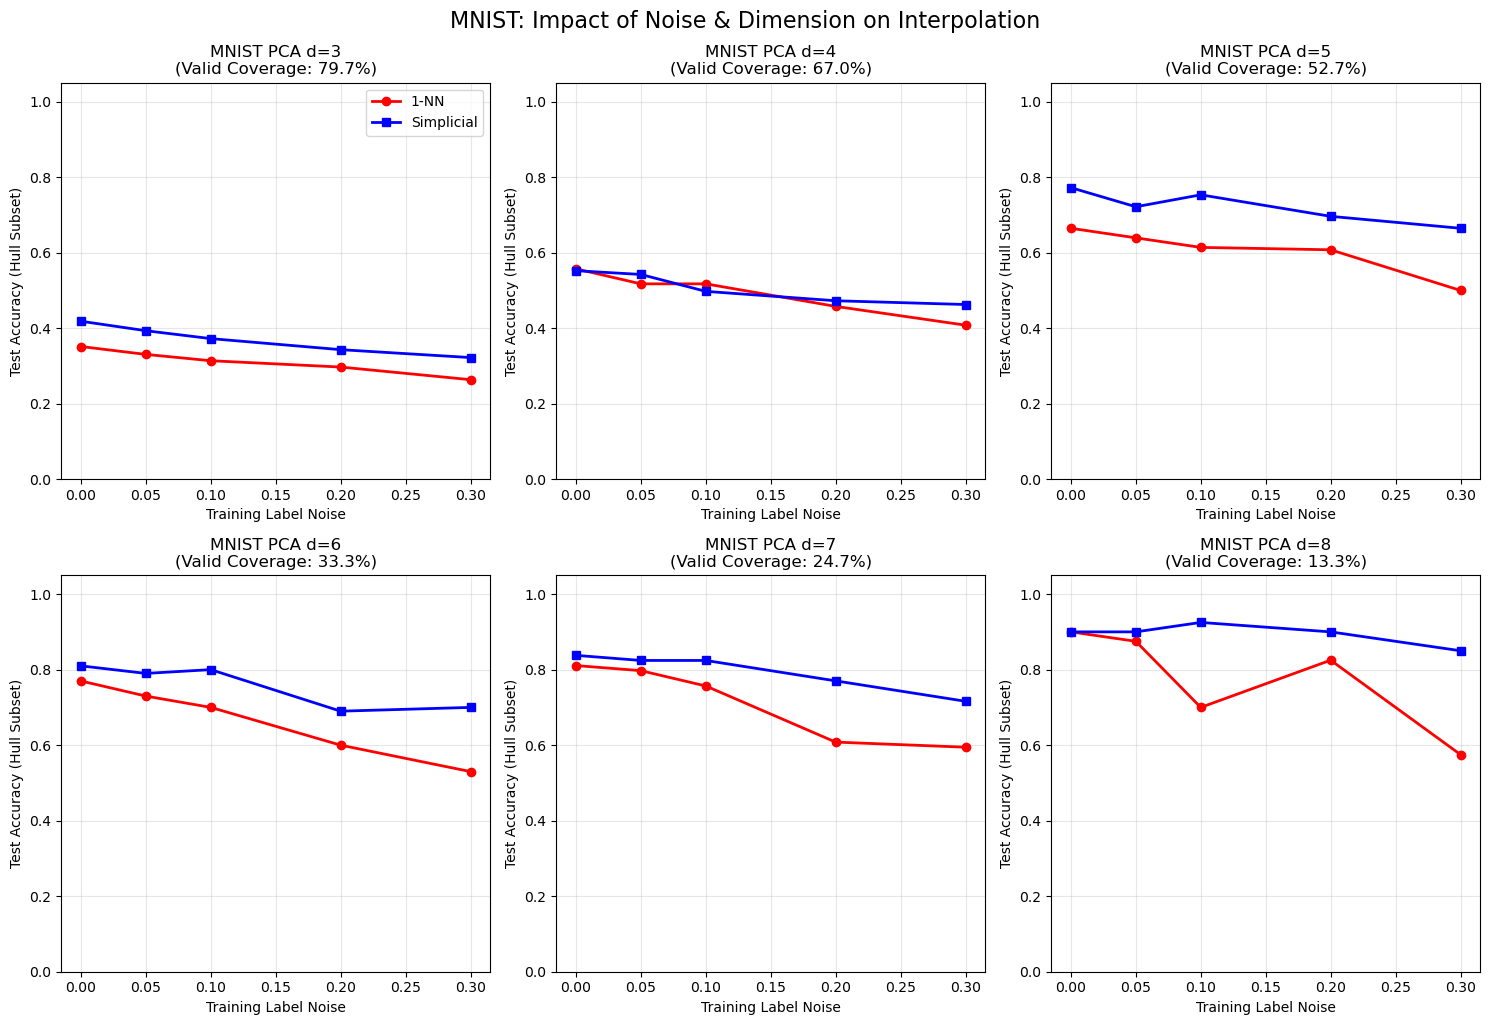

In [6]:
print("Loading MNIST (subset)...")
X_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')

y_raw = y_raw.astype(int)

# Split first, then we will PCA inside the loop
X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(X_raw, y_raw, test_size=0.15, random_state=42)

# Limit test set size for the Simplicial loop (Linear Programming is CPU heavy)
X_te_raw = X_te_raw[:300]
y_te = y_te[:300]

print(f"Train size: {len(y_tr)}, Test size: {len(y_te)}")


d_values = range(3, 9) # Dimensions 3 to 8
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]

# Store results for plotting
plot_data = {} 

print(f"Running Experiment on MNIST for d={list(d_values)}...")

for d in d_values:
    print(f"\n--- Dimension {d} ---")
    
    # Apply PCA for this specific dimension
    pca = PCA(n_components=d)
    X_train = pca.fit_transform(X_tr_raw)
    X_test = pca.transform(X_te_raw)
    
    # Store metrics for this d
    accs_1nn = []
    accs_lsi = []
    coverages = []
    
    # Scale k neighbors relative to d (heuristic: 3*d usually gives enough hull candidates)
    k_simplicial = d * 3
    
    for noise in noise_levels:
        # A. Inject Noise
        y_train_noisy = y_tr.copy()
        n_noise = int(noise * len(y_tr))
        
        if n_noise > 0:
            noise_idx = np.random.choice(len(y_tr), n_noise, replace=False)
            random_shift = np.random.randint(1, 10, size=n_noise)
            y_train_noisy[noise_idx] = (y_train_noisy[noise_idx] + random_shift) % 10
            
        # B. Train Models
        # 1-NN
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_train, y_train_noisy)
        
        # Simplicial
        lsi = LocalSimplicialInterpolator(k_neighbors=k_simplicial)
        lsi.fit(X_train, y_train_noisy)
        
        # C. Predict
        pred_1nn = knn.predict(X_test)
        pred_lsi = lsi.predict(X_test)
        
        # D. Evaluate ONLY on valid hull points
        valid_mask = pred_lsi != -1
        n_valid = np.sum(valid_mask)
        coverage_pct = n_valid / len(y_te)
        
        if n_valid > 0:
            score_1nn = accuracy_score(y_te[valid_mask], pred_1nn[valid_mask])
            score_lsi = accuracy_score(y_te[valid_mask], pred_lsi[valid_mask])
        else:
            score_1nn = np.nan # No data to compare
            score_lsi = np.nan
            
        accs_1nn.append(score_1nn)
        accs_lsi.append(score_lsi)
        
        if noise == 0.0: # Print coverage once per dimension
             coverages.append(coverage_pct) # store for title
             
        # Optional: Print progress line
        # print(f"  Noise {noise*100:.0f}% -> Cov: {coverage_pct:.1%} | 1NN: {score_1nn:.3f} LSI: {score_lsi:.3f}")

    plot_data[d] = {
        'noise': noise_levels,
        '1nn': accs_1nn,
        'lsi': accs_lsi,
        'avg_cov': np.mean(coverages) if coverages else 0
    }

# ==========================================
# 4. PLOTTING RESULTS
# ==========================================


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, d in enumerate(d_values):
    ax = axes[i]
    data = plot_data[d]
    
    # Plot lines
    ax.plot(data['noise'], data['1nn'], 'r-o', label='1-NN', linewidth=2)
    ax.plot(data['noise'], data['lsi'], 'b-s', label='Simplicial', linewidth=2)
    
    # Formatting
    ax.set_title(f"MNIST PCA d={d}\n(Valid Coverage: {data['avg_cov']:.1%})")
    ax.set_xlabel("Training Label Noise")
    ax.set_ylabel("Test Accuracy (Hull Subset)")
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    
    # Handle NaN cases (if coverage was 0)
    if np.isnan(data['lsi']).all():
        ax.text(0.5, 0.5, "Coverage = 0%\nCannot Evaluate", 
                ha='center', va='center', transform=ax.transAxes, color='red')
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle("MNIST: Impact of Noise & Dimension on Interpolation", y=1.02, fontsize=16)
plt.show()